# Predicting NHL High Scoring Games

### IMPORTS

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [32]:
import itertools
from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!


from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier)

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.dummy import DummyClassifier

### Importing Data

In [3]:
nhl_data = pd.read_csv('nhl_over_under_table.csv')

In [4]:
nhl_data.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
nhl_data.head()

,homedivision,hometeam,date,awayteam,homeresult,datetime,totalpoints,homefivegoalsfor,homefivegoalsagainst,hometengoalsfor,...,hometengoaldiff,awayfivegoaldiff,awaytengoaldiff,samedivision,win,homefivetotalgoals,hometentotalgoals,awayfivetotalgoals,awaytentotalgoals,over
0,Atlantic,Tampa Bay,12/27/18,Philadelphia,Win,2018-12-27,11,24.0,15.0,51.0,...,24.0,-2.0,-9.0,0,1,39.0,78.0,26.0,65.0,1
1,Atlantic,Tampa Bay,12/29/18,Montreal,Win,2018-12-29,11,26.0,19.0,52.0,...,21.0,-1.0,2.0,1,1,45.0,83.0,25.0,62.0,1
2,Atlantic,Tampa Bay,1/8/19,Columbus,Win,2019-01-08,4,22.0,18.0,46.0,...,13.0,1.0,6.0,0,1,40.0,79.0,35.0,52.0,0
3,Atlantic,Tampa Bay,1/10/19,Carolina,Win,2019-01-10,4,20.0,13.0,46.0,...,14.0,8.0,0.0,0,1,33.0,78.0,34.0,56.0,0
4,Atlantic,Tampa Bay,1/17/19,Toronto,Loss,2019-01-17,6,15.0,9.0,37.0,...,10.0,-1.0,-1.0,1,0,24.0,64.0,29.0,63.0,0


### Creating a Numeric DataFrame

In [6]:
nhl_num = nhl_data.drop(['homedivision', 'awaydivision', 'hometeam', 'awayteam', 'date', 'homeresult', 'datetime', 'awayresult'], axis=1)

In [7]:
nhl_num.drop(['homelastfiveloss', 'homelastfiveties', 'homelasttenloss', 'homelasttenties', 
             'awaylastfiveloss', 'awaylastfiveties', 'awaylasttenloss', 'awaylasttenties'], axis=1, inplace=True)

In [8]:
nhl_num_ten = nhl_num.copy()

In [9]:
nhl_num_ten.columns

Index(['totalpoints', 'homefivegoalsfor', 'homefivegoalsagainst',
       'hometengoalsfor', 'hometengoalsagainst', 'homelastfivewins',
       'homelasttenwins', 'homefivewinpct', 'hometenwinpct',
       'awayfivegoalsfor', 'awayfivegoalsagainst', 'awaytengoalsfor',
       'awaytengoalsagainst', 'awaylastfivewins', 'awaylasttenwins',
       'awayfivewinpct', 'awaytenwinpct', 'tenwinpctdiff',
       'tengamegoalfordiff', 'fivegamegoalfordiff', 'tengamegoalagainstdiff',
       'fivegamegoalagainstdiff', 'homefivegoaldiff', 'hometengoaldiff',
       'awayfivegoaldiff', 'awaytengoaldiff', 'samedivision', 'win',
       'homefivetotalgoals', 'hometentotalgoals', 'awayfivetotalgoals',
       'awaytentotalgoals', 'over'],
      dtype='object')

In [10]:
nhl_num_ten.drop(['homefivegoalsfor', 'homefivegoalsagainst', 'homelastfivewins', 'homefivewinpct', 
                  'awayfivegoalsfor', 'awayfivegoalsagainst', 'awaylastfivewins', 'awayfivewinpct', 
                  'fivegamegoalfordiff', 'fivegamegoalagainstdiff', 'homefivegoaldiff', 'awayfivegoaldiff',
                 'homefivetotalgoals', 'awayfivetotalgoals', 'totalpoints'], axis=1, inplace=True)

In [11]:
nhl_num_ten['tengoaldiff'] = nhl_num_ten['hometengoaldiff'] - nhl_num_ten['awaytengoaldiff']

In [12]:
nhl_num_ten

,hometengoalsfor,hometengoalsagainst,homelasttenwins,hometenwinpct,awaytengoalsfor,awaytengoalsagainst,awaylasttenwins,awaytenwinpct,tenwinpctdiff,tengamegoalfordiff,tengamegoalagainstdiff,hometengoaldiff,awaytengoaldiff,samedivision,win,hometentotalgoals,awaytentotalgoals,over,tengoaldiff
0,51.0,27.0,9.0,0.9,28.0,37.0,4.0,0.4,0.5,23.0,-10.0,24.0,-9.0,0,1,78.0,65.0,1,33.0
1,52.0,31.0,9.0,0.9,32.0,30.0,7.0,0.7,0.2,20.0,1.0,21.0,2.0,1,1,83.0,62.0,1,19.0
2,46.0,33.0,8.0,0.8,29.0,23.0,7.0,0.7,0.1,17.0,10.0,13.0,6.0,0,1,79.0,52.0,0,7.0
3,46.0,32.0,8.0,0.8,28.0,28.0,6.0,0.6,0.2,18.0,4.0,14.0,0.0,0,1,78.0,56.0,0,14.0
4,37.0,27.0,8.0,0.8,31.0,32.0,5.0,0.5,0.3,6.0,-5.0,10.0,-1.0,1,0,64.0,63.0,0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,22.0,36.0,2.0,0.2,33.0,32.0,6.0,0.6,-0.4,-11.0,4.0,-14.0,1.0,1,1,58.0,65.0,0,-15.0
772,25.0,32.0,3.0,0.3,33.0,30.0,6.0,0.6,-0.3,-8.0,2.0,-7.0,3.0,1,1,57.0,63.0,0,-10.0
773,28.0,32.0,4.0,0.4,28.0,22.0,6.0,0.6,-0.2,0.0,10.0,-4.0,6.0,0,1,60.0,50.0,0,-10.0
774,29.0,30.0,5.0,0.5,39.0,20.0,7.0,0.7,-0.2,-10.0,10.0,-1.0,19.0,1,0,59.0,59.0,1,-20.0


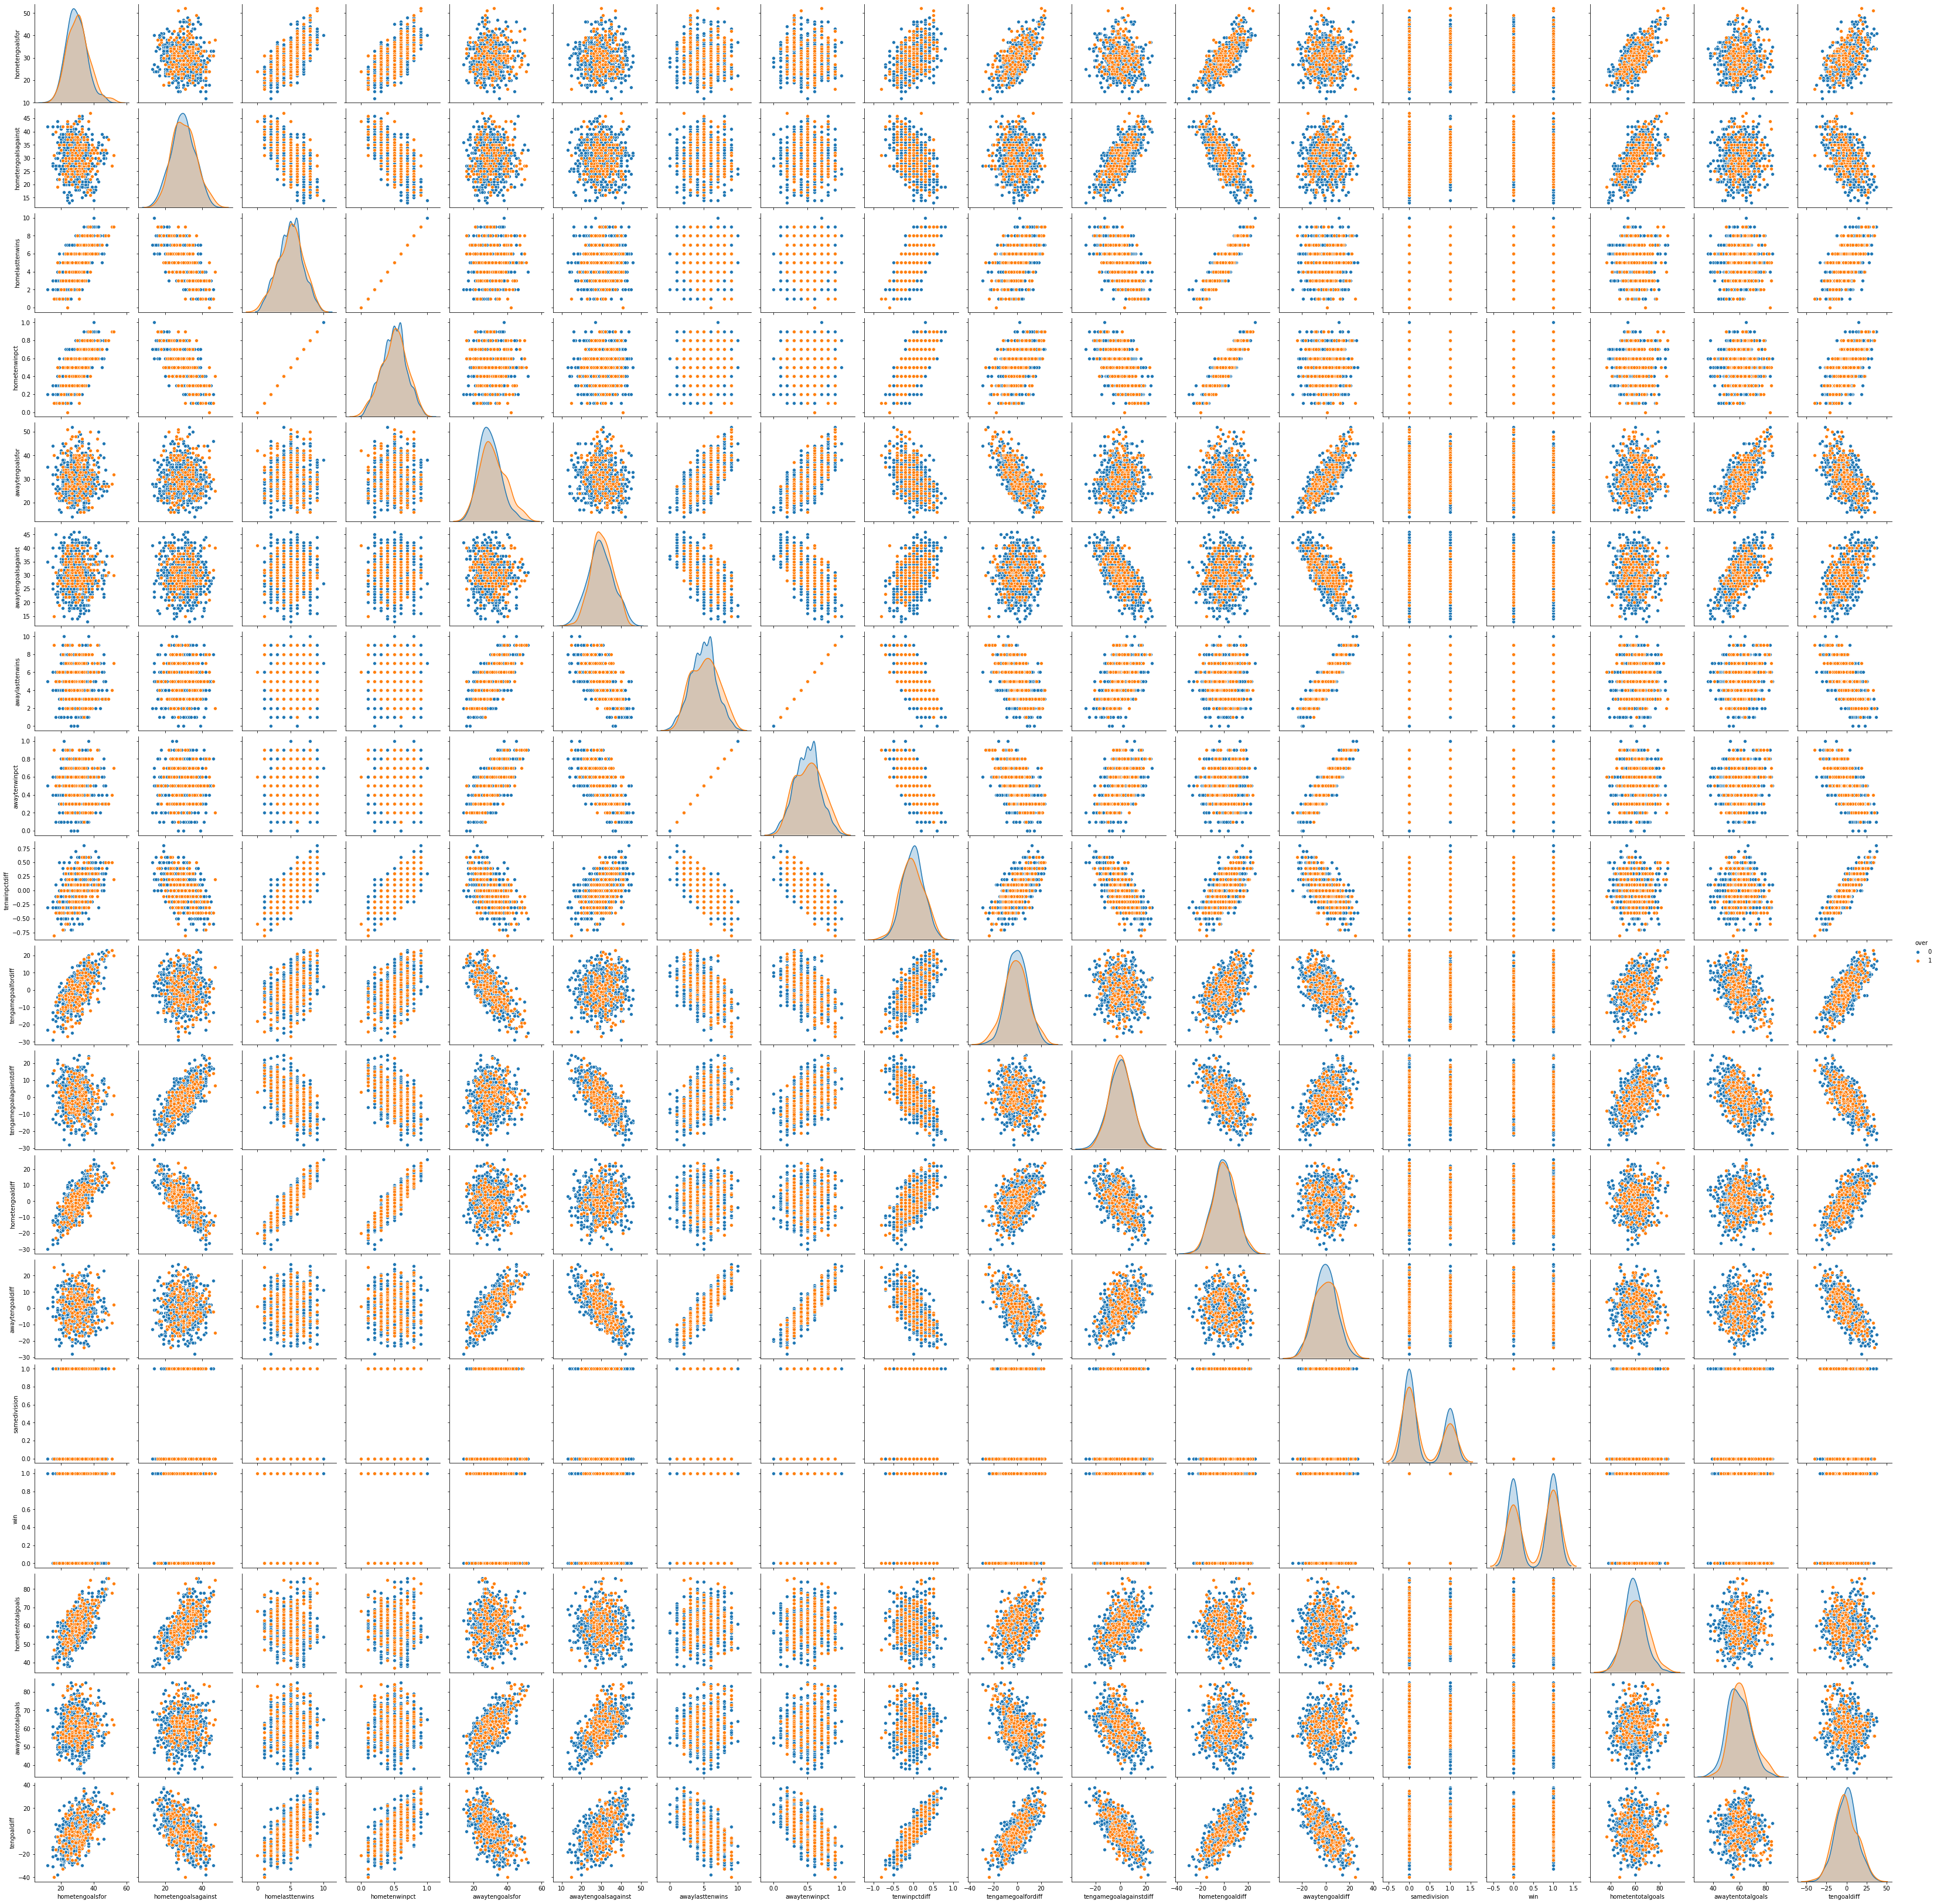

In [13]:
sns.pairplot(nhl_num_ten, hue='over')

In [44]:
nhl_num_ten.columns

Index(['hometengoalsfor', 'hometengoalsagainst', 'homelasttenwins',
       'hometenwinpct', 'awaytengoalsfor', 'awaytengoalsagainst',
       'awaylasttenwins', 'awaytenwinpct', 'tenwinpctdiff',
       'tengamegoalfordiff', 'tengamegoalagainstdiff', 'hometengoaldiff',
       'awaytengoaldiff', 'samedivision', 'win', 'hometentotalgoals',
       'awaytentotalgoals', 'over', 'tengoaldiff'],
      dtype='object')

In [83]:
nhl_num_ten.drop(['win', 'homelasttenwins', 'awaylasttenwins', 'hometenwinpct', 'awaytenwinpct', 'tenwinpctdiff'], axis=1, inplace=True)

In [47]:
nhl_num_ten.drop('samedivision', axis=1, inplace=True)

In [48]:
nhl_num_ten.columns

Index(['hometengoalsfor', 'hometengoalsagainst', 'awaytengoalsfor',
       'awaytengoalsagainst', 'tengamegoalfordiff', 'tengamegoalagainstdiff',
       'hometengoaldiff', 'awaytengoaldiff', 'hometentotalgoals',
       'awaytentotalgoals', 'over', 'tengoaldiff'],
      dtype='object')

### Model Prep

The best features are in the X frame below

In [675]:
X = nhl_num_ten[['awaytengoalsfor', 'hometengoalsfor', 'hometentotalgoals', 'awaytentotalgoals']]
y = nhl_num_ten['over']

In [676]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

### Baseline Model

Using F1 as Main Scoring Metric

In [51]:
y_train.shape

(620,)

In [52]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
lr.score(X_train, [0]*620)

1.0

In [53]:
f1_score(y_train, [0]*620)

0.0

In [54]:
roc_auc_score(y_train, [0]*620)

0.5

Baseline F1 Score (the score to beat): 0.0  
Baseline ROC-AUC Score: 0.5

#### Using SMOTE to deal with some imbalanced classes

In [319]:
import imblearn.over_sampling

In [464]:
n_neg/n_pos

3.3893805309734515

In [677]:
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 2, 0 : n_neg} 

smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
X_tr_smote, y_tr_smote = smote.fit_sample(X_train, y_train)

### Testing Multiple Models

In [ ]:
X_tr_smote, X_val, y_tr_smote, y_val = train_test_split(X_tr_smote, y_tr_smote, test_size=0.2, random_state=30)

In [561]:
lr_smote = LogisticRegression() 
lr_smote.fit(X_tr_smote, y_tr_smote)

print('Logistic Regression on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val, lr_smote.predict(X_val)), roc_auc_score(y_val, lr_smote.predict_proba(X_val)[:,1])))

Logistic Regression on SMOTE Train Data; Test F1: 0.261, Test AUC: 0.550


In [652]:
rf_smote = RandomForestClassifier(n_estimators=300, min_samples_leaf=18, max_features=2, max_depth=12) 
rf_smote.fit(X_tr_smote, y_tr_smote)

print('Random Forest on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val, rf_smote.predict(X_val)), roc_auc_score(y_val, rf_smote.predict_proba(X_val)[:,1])))

Random Forest on SMOTE Train Data; Test F1: 0.389, Test AUC: 0.803


In [653]:
print('Random Forest on SMOTE Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_tr_smote, rf_smote.predict(X_tr_smote)), roc_auc_score(y_val, rf_smote.predict_proba(X_val)[:,1])))

Random Forest on SMOTE Train Data; Test F1: 0.517, Test AUC: 0.803


In [567]:
rf_smote.feature_importances_

array([0.38390675, 0.144857  , 0.26045234, 0.21078391])

In [568]:
X_tr_smote.columns

Index(['awaytengoalsfor', 'hometengoalsfor', 'hometentotalgoals',
       'awaytentotalgoals'],
      dtype='object')

### Also Tested Models without SMOTE at the very beginning 

In [280]:
knn = KNeighborsClassifier()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gnb = GaussianNB()
sv = svm.SVC()
xgb = GradientBoostingClassifier()


models = [knn, lr, dt, rf, gnb, sv, xgb]
for model in models:
    print(model, cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc'), 
          'mean=', cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean())

KNeighborsClassifier() [0.55631868 0.5200157  0.58163265 0.54415228 0.53913708] mean= 0.5482512768963431
LogisticRegression() [0.59536892 0.64913658 0.48587127 0.60832025 0.55479191] mean= 0.5786977845151631
DecisionTreeClassifier() [0.49293564 0.55062794 0.54160126 0.605573   0.55841924] mean= 0.5542270199118505
RandomForestClassifier() [0.61675824 0.62519623 0.57142857 0.56200942 0.53092784] mean= 0.5732963226704022
GaussianNB() [0.56907378 0.60596546 0.51530612 0.58398744 0.58075601] mean= 0.57101776475856
SVC() [0.62598116 0.51726845 0.46899529 0.66875981 0.56701031] mean= 0.5696030037708978
GradientBoostingClassifier() [0.65541601 0.69348509 0.58084772 0.54689953 0.51699122] mean= 0.60487376993268


Top 3 at first glance: Logistic Regression, Random Forest, XGBoost

In [282]:
knn = KNeighborsClassifier()
lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gnb = GaussianNB()
sv = svm.SVC()
xgb = GradientBoostingClassifier()

models = [knn, lr, dt, rf, gnb, sv, xgb]
for model in models:
    print(model, cross_val_score(model, X_train, y_train, cv=5, scoring='f1'), 
          'mean=', cross_val_score(model, X_train, y_train, cv=5, scoring='f1').mean())

KNeighborsClassifier() [0.1875     0.16666667 0.17142857 0.20512821 0.25      ] mean= 0.19614468864468865
LogisticRegression() [0.         0.         0.13333333 0.         0.        ] mean= 0.026666666666666672
DecisionTreeClassifier() [0.28571429 0.31578947 0.26666667 0.37931034 0.32142857] mean= 0.3156331453467631
RandomForestClassifier() [0.12903226 0.15789474 0.20512821 0.3        0.16216216] mean= 0.193222519538309
GaussianNB() [0.17647059 0.22857143 0.22727273 0.27027027 0.27272727] mean= 0.2350624574153986
SVC() [0. 0. 0. 0. 0.] mean= 0.0
GradientBoostingClassifier() [0.27777778 0.12121212 0.21621622 0.27777778 0.21621622] mean= 0.21920054025317182


Back to the top to deal with some Class Imbalance


In [569]:
import pickle
pickle.dump(rf_smote, open('pickle_rf_model.p', 'wb'))

## Cross Validating with Random Forest and using SMOTE

In [635]:
cross_validate(rf_smote, X_tr_smote, y_tr_smote, cv=5, scoring=['f1', 'roc_auc'], return_train_score=True)

{'fit_time': array([1.12740779, 0.66500401, 0.7186172 , 0.63895607, 0.66807294]),
 'score_time': array([0.0821321 , 0.1008718 , 0.08150983, 0.09165382, 0.09570503]),
 'test_f1': array([0.39473684, 0.47887324, 0.39534884, 0.57777778, 0.4047619 ]),
 'train_f1': array([0.52439024, 0.50755287, 0.50154799, 0.47826087, 0.47384615]),
 'test_roc_auc': array([0.6909896 , 0.69799843, 0.66051805, 0.80317896, 0.65726512]),
 'train_roc_auc': array([0.82668657, 0.82693947, 0.83274266, 0.80940202, 0.81007714])}

RF_SMOTE appears to be the best one, this is the one I shall choose :)

In [627]:
gb = GradientBoostingClassifier()
gb.fit(X_tr_smote, y_tr_smote)

GradientBoostingClassifier()

In [628]:
cross_validate(gb, X_tr_smote, y_tr_smote, cv=5, scoring=['f1', 'roc_auc'], return_train_score=True)

{'fit_time': array([0.23333597, 0.1183691 , 0.11347795, 0.11571717, 0.15568089]),
 'score_time': array([0.0175519 , 0.00769997, 0.00693083, 0.00652504, 0.01631427]),
 'test_f1': array([0.36923077, 0.25      , 0.63414634, 0.65853659, 0.64367816]),
 'train_f1': array([0.82242991, 0.88288288, 0.80128205, 0.81504702, 0.81388013]),
 'test_roc_auc': array([0.62828947, 0.58773449, 0.73997114, 0.77171717, 0.76827485]),
 'train_roc_auc': array([0.96063156, 0.97363955, 0.95209981, 0.93949735, 0.94626307])}

Gradient Boost seems to be promising, but definitely is overfitting and im not quite sure how to adjust the hyperparameters yet :)  
See bottom of document for more gradient boosting

### Results using Random Forest with SMOTE

###### This is the best model i could create

I did some manual hyperparameter tuning before this to try and get as little overfitting as I could

In [663]:
rf_smote.fit(X_tr_smote, y_tr_smote)

RandomForestClassifier(max_depth=12, max_features=2, min_samples_leaf=13,
                       n_estimators=300)

In [665]:
f1_score(y_test, rf_smote.predict(np.array(X_test)))

0.2857142857142857

In [668]:
roc_auc_score(y_test, rf_smote.predict(np.array(X_test)))

0.569047619047619

In [672]:
accuracy_score(y_test, rf_smote.predict(np.array(X_test)))

0.7756410256410257

In [673]:
precision_score(y_test, rf_smote.predict(np.array(X_test)))

0.3684210526315789

In [674]:
recall_score(y_test, rf_smote.predict(np.array(X_test)))

0.23333333333333334

### Attempting to hyperparameter tune Random Forest with Grid Search

In [680]:
from sklearn.model_selection import GridSearchCV

grid = { "n_estimators": [100,200,500],
           "criterion": ["gini", "entropy"],
           "max_features": [1,2,3],
            "min_samples_leaf": [5,7,10,12,15,17,20],
           "max_depth": [3,4,6,10]
         }

rf_grid = RandomForestClassifier()
grid_search = GridSearchCV(rf_grid, grid, n_jobs=-1, cv=5)

grid_search.fit(X_tr_smote, y_tr_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 6, 10], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [5, 7, 10, 12, 15, 17, 20],
                         'n_estimators': [100, 200, 500]})

In [681]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 3,
 'min_samples_leaf': 5,
 'n_estimators': 100}

In [682]:
rf_grid = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, max_features=3, max_depth=10)
rf_grid.fit(X_tr_smote, y_tr_smote)

RandomForestClassifier(max_depth=10, max_features=3, min_samples_leaf=5)

In [683]:
print(cross_val_score(rf_grid, X_tr_smote, y_tr_smote, cv=5, scoring='f1'))
print(cross_val_score(rf_grid, X_tr_smote, y_tr_smote, cv=5, scoring='f1').mean())
print(cross_val_score(rf_grid, X_tr_smote, y_tr_smote, cv=5, scoring='recall'))
print(cross_val_score(rf_grid, X_tr_smote, y_tr_smote, cv=5, scoring='precision'))

[0.45       0.42253521 0.46511628 0.70833333 0.54945055]
0.5178798542311889
[0.33962264 0.25       0.36538462 0.57692308 0.49056604]
[0.7037037  0.8125     0.59375    0.74468085 0.63414634]


These Parameters looked to be okay, but had much more overfitting than the hyperparameters that I had manually tuned for, so I stayed with RF_SMOTE as the best model

I also tried some Gradient Boosting Classification, but all of the attempts here involved a lot of overfitting, and therefor a poor model

In [686]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=.1, subsample=1, 
                               min_samples_split=2, min_samples_leaf=1, max_depth=3, 
                               max_features=3)
gb.fit(X_tr_smote, y_tr_smote)

GradientBoostingClassifier(max_features=3, subsample=1)

In [687]:
cross_validate(gb, X_tr_smote, y_tr_smote, cv=5, scoring=['f1', 'roc_auc'], return_train_score=True)

{'fit_time': array([0.17280912, 0.10230613, 0.11906385, 0.11082768, 0.09849596]),
 'score_time': array([0.03849792, 0.0073781 , 0.00671816, 0.00848007, 0.00776291]),
 'test_f1': array([0.4109589 , 0.41666667, 0.48351648, 0.65217391, 0.62222222]),
 'train_f1': array([0.79452055, 0.81940701, 0.7867036 , 0.73198847, 0.74033149]),
 'test_roc_auc': array([0.73382749, 0.72095761, 0.7269427 , 0.85076531, 0.79634312]),
 'train_roc_auc': array([0.9525447 , 0.95473146, 0.95285592, 0.92994154, 0.9258007 ])}

In [690]:
grid = { "n_estimators": [100,200,500],
        "learning_rate":[.1, .2, .3, .4, .5, .6, .7],
           "subsample": [1],
        "min_samples_split": [2,4,6,8,10],
           "max_features": [1,2,3],
            "min_samples_leaf": [5,7,10,12,15,17,20],
           "max_depth": [3,4,6,10]
         }

gb_grid = GradientBoostingClassifier()
grid_search = GridSearchCV(gb_grid, grid, n_jobs=-1, cv=5)

grid_search.fit(X_tr_smote, y_tr_smote)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                         'max_depth': [3, 4, 6, 10], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [5, 7, 10, 12, 15, 17, 20],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [100, 200, 500], 'subsample': [1]})

In [691]:
grid_search.best_params_

{'learning_rate': 0.2,
 'max_depth': 6,
 'max_features': 3,
 'min_samples_leaf': 12,
 'min_samples_split': 2,
 'n_estimators': 100,
 'subsample': 1}

In [693]:
gb_grid = GradientBoostingClassifier(learning_rate= 0.2, max_depth= 6, max_features= 3, 
                                     min_samples_leaf= 12, min_samples_split= 2, n_estimators= 100, subsample= 1)

In [694]:
print(cross_val_score(gb_grid, X_tr_smote, y_tr_smote, cv=5, scoring='f1'))
print(cross_val_score(gb_grid, X_tr_smote, y_tr_smote, cv=5, scoring='f1').mean())
print(cross_val_score(gb_grid, X_tr_smote, y_tr_smote, cv=5, scoring='recall'))
print(cross_val_score(gb_grid, X_tr_smote, y_tr_smote, cv=5, scoring='precision'))

[0.39534884 0.43181818 0.52747253 0.78333333 0.73584906]
0.5737439702494613
[0.32075472 0.40384615 0.48076923 0.86538462 0.75471698]
[0.5        0.5        0.61363636 0.69565217 0.68333333]


In [695]:
cross_validate(gb_grid, X_tr_smote, y_tr_smote, cv=5, scoring=['f1', 'roc_auc'], return_train_score=True)

{'fit_time': array([0.15118814, 0.13577986, 0.12988114, 0.12822604, 0.12969398]),
 'score_time': array([0.06038499, 0.00812006, 0.00645089, 0.00640512, 0.00640512]),
 'test_f1': array([0.45783133, 0.46511628, 0.51111111, 0.79646018, 0.74545455]),
 'train_f1': array([0.99760192, 0.99521531, 0.97584541, 0.98313253, 0.97297297]),
 'test_roc_auc': array([0.69252984, 0.69309262, 0.73645997, 0.90364992, 0.87395448]),
 'train_roc_auc': array([0.99997553, 0.99993911, 0.99858726, 0.99951285, 0.99873059])}

SEVERE OVERFITTING!!!!!